In [1]:
import tensorflow as tf
import os
import jax
from jax.lib import xla_bridge

# Set the CUDA_VISIBLE_DEVICES environment variable
os.environ["CUDA_VISIBLE_DEVICES"] = str('2')
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-12.1"

# Checking for GPU access
print("Device: {}".format(xla_bridge.get_backend().platform))

# Checking the GPU available
gpus = jax.devices("gpu")
print("Number of avaliable devices : {}".format(len(gpus)))

# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type="GPU")

2023-07-06 16:15:34.792547: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 16:15:34.845466: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 16:15:35.699585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Device: gpu
Number of avaliable devices : 1


In [2]:
import tensorflow_datasets as tfds
from galsim_jax.datasets import cosmos
import numpy as np
from astropy.stats import mad_std

In [3]:
# Loading the dataset and transforming it to NumPy Arrays
train_dset, info = tfds.load(name="Cosmos/25.2", with_info=True, split="train")

In [4]:
info

tfds.core.DatasetInfo(
    name='cosmos',
    full_name='cosmos/25.2/0.0.1',
    description="""
    
    """,
    config_description="""
    Cosmos stamps from 25.2 sample in 128 x 128 resolution, 0.03 arcsec/pixel.
    """,
    homepage='https://dataset-homepage/',
    data_path='/local/home/jt275011/tensorflow_datasets/cosmos/25.2/0.0.1',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=6.11 GiB,
    features=FeaturesDict({
        'image': Tensor(shape=(128, 128), dtype=float32),
        'noise_std': Scalar(shape=(), dtype=float32),
        'psf': Tensor(shape=(128, 128), dtype=float32),
    }),
    supervised_keys=('image', 'image'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=16>,
        'train': <SplitInfo num_examples=40000, num_shards=64>,
    },
    citation="""""",
)

In [5]:
# Dataset as a numpy iterator
dset = train_dset.as_numpy_iterator()

2023-07-06 16:15:38.019107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [64]
	 [[{{node Placeholder/_1}}]]
2023-07-06 16:15:38.019488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [64]
	 [[{{node Placeholder/_4}}]]


In [6]:
# Taking 64 images of the dataset
batch_im = next(dset)

In [7]:
type(batch_im)

dict

In [8]:
batch_im["image"].shape

(128, 128)

In [9]:
batch_im["psf"].shape

(128, 128)

In [10]:
batch_im["noise_std"]

0.0022913206

In [11]:
# Using a mapping function to apply preprocessing to our data
def preprocessing(example):
    img = tf.math.asinh(example["image"] / tf.constant(scaling) / 3.0)
    # psf = tf.math.asinh(example["psf"] / tf.constant(scaling) / 3.0)
    # img = jnp.arcsinh(example["image"] / scaling / 3.0)
    # We return the image as our input and output for a generative model
    return img  # , psf

In [12]:
def input_fn(mode="train", batch_size=64):
    """
    mode: 'train' or 'test'
    """

    def preprocess_image(data):
        # Reshape 'psf' and 'image' to (128, 128, 1)
        data['psf'] = tf.expand_dims(data['psf'], axis=-1)
        data["image"] = tf.expand_dims(data["image"], axis=-1)
        return data

    if mode == "train":
        dataset = tfds.load(name="Cosmos/25.2", split="train[:80%]")
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
    else:
        dataset = tfds.load(name="Cosmos/25.2", split="train[80%:]")

    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(preprocess_image)
    dataset = dataset.prefetch(
        -1
    )  # fetch next batches while training current one (-1 for autotune)
    return dataset


# Dataset as a numpy iterator
dset = input_fn().as_numpy_iterator()

2023-07-06 16:15:38.257619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [52]
	 [[{{node Placeholder/_1}}]]
2023-07-06 16:15:38.258129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [52]
	 [[{{node Placeholder/_2}}]]


In [13]:
# Taking 64 images of the dataset
batch_im = next(dset)

In [14]:
batch_im["image"].shape

(64, 128, 128, 1)

In [15]:
batch_im["psf"].mean()

6.1035156e-05

In [16]:
batch_im["noise_std"].shape

(64,)

In [17]:
std = batch_im["noise_std"]
std = std[:16]

In [18]:
std

array([0.00359515, 0.00245439, 0.00219997, 0.00217648, 0.00353473,
       0.00228431, 0.00220028, 0.00239301, 0.00233164, 0.00347522,
       0.00363509, 0.00243457, 0.00229365, 0.00241164, 0.00249896,
       0.00235857], dtype=float32)

In [19]:
batch_im.keys()

dict_keys(['image', 'noise_std', 'psf'])

In [20]:
dataset_eval = input_fn("test")
test_iterator = dataset_eval.as_numpy_iterator()

2023-07-06 16:15:38.849699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [13]
	 [[{{node Placeholder/_1}}]]
2023-07-06 16:15:38.850140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [13]
	 [[{{node Placeholder/_1}}]]


In [21]:
# Taking 64 images of the dataset
batch_im_t = next(test_iterator)

In [22]:
x = batch_im_t["image"]

In [23]:
psf = batch_im_t["psf"]

<Figure size 1000x400 with 0 Axes>

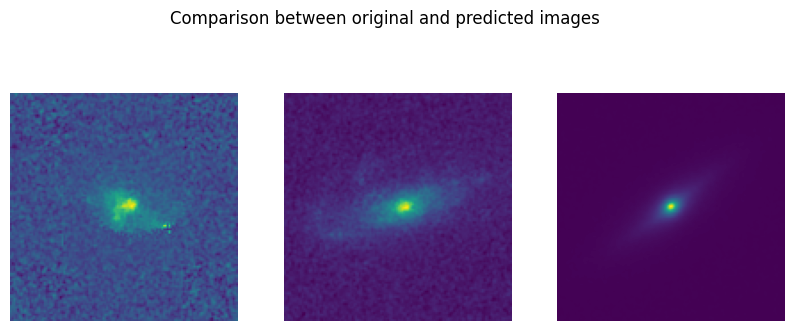

In [24]:
z = x[11:14, ...]

import matplotlib.pyplot as plt

# Plotting the original, predicted and their differences for 8 examples
num_rows, num_cols = 1, 3

plt.figure(figsize=(10, 4))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 4))

for ax, z_img in zip(axes.flatten(), z):
    ax.imshow(z_img.mean(axis=-1))
    ax.axis("off")

# Add a title to the figure
fig.suptitle("Comparison between original and predicted images", fontsize=12, y=0.99);

In [25]:
import jax.numpy as jnp
import numpy as np
from flax import linen as nn
from tensorflow_probability.substrates import jax as tfp

# Loading distributions from TensorFlow Probability (JAX version)
tfd = tfp.distributions


def Normalize(num_groups=10):
    return nn.GroupNorm(num_groups=num_groups, epsilon=1e-6, use_scale=True)


class Downsample(nn.Module):
    in_channels: int

    def setup(self):
        self.conv = nn.Conv(
            self.in_channels,
            kernel_size=(3, 3),
            strides=(2, 2),
            padding=((0, 1), (0, 1)),
        )

    def __call__(self, x):
        pad = ((0, 0), (0, 1), (0, 0), (0, 1))
        x = jnp.pad(x, pad, mode="constant", constant_values=0)
        x = self.conv(x)
        return x


class ResnetBlock(nn.Module):
    in_channels: int
    out_channels: int
    act_fn: callable = nn.gelu  # Activation function

    def setup(self):
        self.norm1 = Normalize(num_groups=1)
        self.conv1 = nn.Conv(
            self.out_channels,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding=((1, 1), (1, 1)),
        )
        self.norm2 = Normalize(num_groups=1)
        self.conv2 = nn.Conv(
            self.out_channels,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding=((1, 1), (1, 1)),
        )

        self.nin_shortcut = nn.Conv(
            self.out_channels,
            kernel_size=(1, 1),
            strides=(1, 1),
            padding=((0, 0), (0, 0)),
        )

    def __call__(self, x):
        h = x
        h = self.norm1(h)
        h = self.act_fn(h)
        h = self.conv1(h)
        h = self.norm2(h)
        h = self.act_fn(h)
        h = self.conv2(h)
        x = self.nin_shortcut(x)
        x_ = x + h

        return x + h


class DownsamplingBlock(nn.Module):
    ch: int
    ch_mult: tuple
    num_res_blocks: int
    resolution: int
    block_idx: int
    act_fn: callable = nn.gelu  # Activation function

    def setup(self):
        self.ch_mult_ = self.ch_mult
        self.num_resolutions = len(self.ch_mult_)
        in_ch_mult = (1,) + tuple(self.ch_mult_)
        block_in = self.ch * in_ch_mult[self.block_idx]
        block_out = self.ch * self.ch_mult_[self.block_idx]

        res_blocks = []
        for _ in range(self.num_res_blocks):
            res_blocks.append(ResnetBlock(block_in, block_out, self.act_fn))
        block_in = block_out
        self.block = res_blocks

        self.downsample = None
        if self.block_idx != self.num_resolutions - 1:
            self.downsample = Downsample(block_in)

    def __call__(self, h):
        for i, res_block in enumerate(self.block):
            h = res_block(h)

        if self.downsample is not None:
            h = self.downsample(h)

        return h


class MidBlock(nn.Module):
    in_channels: int

    def setup(self):
        self.block_1 = ResnetBlock(
            self.in_channels,
            self.in_channels,
        )
        self.block_2 = ResnetBlock(
            self.in_channels,
            self.in_channels,
        )

    def __call__(self, h):
        h = self.block_1(h)
        h = self.block_2(h)

        return h


class Encoder(nn.Module):
    ch: int
    out_ch: int
    ch_mult: tuple
    num_res_blocks: int
    in_channels: int
    resolution: int
    z_channels: int
    double_z: bool
    act_fn: callable = nn.gelu  # Activation function

    def setup(self):
        self.num_resolutions = len(self.ch_mult)

        # downsampling
        self.conv_in = nn.Conv(
            self.ch,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding=((1, 1), (1, 1)),
        )

        curr_res = self.resolution
        downsample_blocks = []

        for i_level in range(self.num_resolutions):
            downsample_blocks.append(
                DownsamplingBlock(
                    ch=self.ch,
                    ch_mult=self.ch_mult,
                    num_res_blocks=self.num_res_blocks,
                    resolution=self.resolution,
                    block_idx=i_level,
                    act_fn=self.act_fn,
                )
            )
            if i_level != self.num_resolutions - 1:
                curr_res = curr_res // 2

        self.down = downsample_blocks

        # middle
        mid_channels = self.ch * self.ch_mult[-1]
        self.mid = MidBlock(mid_channels)
        # end
        self.norm_out = Normalize(num_groups=1)
        self.conv_out = nn.Conv(
            self.z_channels * 2 if self.double_z else self.z_channels,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding=((1, 1), (1, 1)),
        )

    def __call__(self, x):
        # downsampling
        print("x :", x.shape)
        hs = self.conv_in(x)
        print("Conv_in :", hs.shape)
        for block in self.down:
            hs = block(hs)
        print("Down :", hs.shape)

        # middle
        hs = self.mid(hs)
        print("Mid :", hs.shape)

        # end
        hs = self.norm_out(hs)
        hs = self.act_fn(hs)
        hs = self.conv_out(hs)
        print("Conv_out :", hs.shape)

        return hs


class Upsample(nn.Module):
    in_channels: int

    def setup(self):
        self.conv = nn.Conv(
            self.in_channels,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding=((1, 1), (1, 1)),
        )

    def __call__(self, hs):
        batch, height, width, channels = hs.shape
        hs = jax.image.resize(
            hs,
            shape=(batch, height * 2, width * 2, channels),
            method="bicubic",
        )
        hs = self.conv(hs)
        return hs


class UpsamplingBlock(nn.Module):
    ch: int
    ch_mult: tuple
    num_res_blocks: int
    resolution: int
    block_idx: int
    act_fn: callable = nn.gelu  # Activation function

    def setup(self):
        self.ch_mult_ = self.ch_mult
        self.num_resolutions = len(self.ch_mult_)

        if self.block_idx == self.num_resolutions - 1:
            block_in = self.ch * self.ch_mult_[-1]
        else:
            block_in = self.ch * self.ch_mult_[self.block_idx + 1]

        block_out = self.ch * self.ch_mult_[self.block_idx]

        res_blocks = []
        for _ in range(self.num_res_blocks + 1):
            res_blocks.append(ResnetBlock(block_in, block_out, self.act_fn))

        block_in = block_out

        self.block = res_blocks

        self.upsample = None
        if self.block_idx != 0:
            self.upsample = Upsample(block_in)

    def __call__(self, h):
        for i, res_block in enumerate(self.block):
            h = res_block(h)

        if self.upsample is not None:
            h = self.upsample(h)

        return h


class Decoder(nn.Module):
    ch: int
    out_ch: int
    ch_mult: tuple
    num_res_blocks: int
    in_channels: int
    resolution: int
    z_channels: int
    double_z: bool
    act_fn: callable = nn.gelu  # Activation function

    def setup(self):
        self.num_resolutions = len(self.ch_mult)

        block_in = self.ch * self.ch_mult[self.num_resolutions - 1]
        curr_res = self.resolution // 2 ** (self.num_resolutions - 1)
        self.z_shape = (1, self.z_channels, curr_res, curr_res)

        # z to block_in
        self.conv_in = nn.Conv(
            self.ch,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding=((1, 1), (1, 1)),
        )

        print(
            "Working with z of shape {} = {} dimensions.".format(
                self.z_shape, np.prod(self.z_shape)
            )
        )

        # middle
        self.mid = MidBlock(block_in)

        # upsampling
        upsample_blocks = []

        for i_level in reversed(range(self.num_resolutions)):
            upsample_blocks.append(
                UpsamplingBlock(
                    ch=self.ch,
                    ch_mult=self.ch_mult,
                    num_res_blocks=self.num_res_blocks,
                    resolution=self.resolution,
                    block_idx=i_level,
                    act_fn=self.act_fn,
                )
            )
            if i_level != 0:
                curr_res = curr_res * 2
        self.up = list(reversed(upsample_blocks))  # reverse to get consistent order

        # end
        self.norm_out = Normalize(num_groups=1)
        self.conv_out = nn.Conv(
            self.out_ch,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding=((1, 1), (1, 1)),
        )

    def __call__(self, z):
        # z to block_in
        hs = self.conv_in(z)

        # middle
        hs = self.mid(hs)

        # upsampling
        for block in reversed(self.up):
            hs = block(hs)

        # end
        hs = self.norm_out(hs)
        hs = self.act_fn(hs)
        hs = self.conv_out(hs)

        return hs


class AutoencoderKLModule(nn.Module):
    ch: int
    out_ch: int
    ch_mult: tuple
    num_res_blocks: int
    in_channels: int
    resolution: int
    z_channels: int
    double_z: bool
    embed_dim: int
    act_fn: callable = nn.gelu  # Activation function

    def setup(self):
        self.encoder = Encoder(
            self.ch,
            self.out_ch,
            self.ch_mult,
            self.num_res_blocks,
            self.in_channels,
            self.resolution,
            self.z_channels,
            self.double_z,
            self.act_fn,
        )
        self.decoder = Decoder(
            self.ch,
            self.out_ch,
            self.ch_mult,
            self.num_res_blocks,
            self.in_channels,
            self.resolution,
            self.z_channels,
            self.double_z,
            self.act_fn,
        )
        self.quant_conv = nn.Conv(
            2 * self.embed_dim,
            kernel_size=(1, 1),
            strides=(1, 1),
            padding="VALID",
        )
        self.post_quant_conv = nn.Conv(
            self.z_channels,
            kernel_size=(1, 1),
            strides=(1, 1),
            padding="VALID",
        )

    def encode(self, x):
        h = self.encoder(x)
        moments = self.quant_conv(h)
        print("Moments shape :", moments.shape)
        posterior = tfd.MultivariateNormalDiag(
            loc=moments[..., : self.z_channels],
            scale_diag=moments[..., self.z_channels :],
        )
        print("Posterior :", posterior)

        return posterior

    def decode(self, h):
        h = self.post_quant_conv(h)
        h = self.decoder(h)
        # Image is now 64x64x5
        # q = tfd.MultivariateNormalDiag(loc=h, scale_diag=[0.01, 0.01, 0.01, 0.01, 0.01])
        return h  # q

    def __call__(self, x, seed):
        posterior = self.encode(x)
        h = posterior.sample(seed=seed)
        q = self.decode(h)

        return q  # , posterior

In [26]:
# Generating a random key for JAX
rng, rng_2 = jax.random.PRNGKey(0), jax.random.PRNGKey(1)
# Size of the input to initialize the encoder parameters
batch_autoenc = jnp.ones((1, 128, 128, 1))

latent_dim = 128
act_fn = nn.gelu

# Initializing the AutoEncoder
Autoencoder = AutoencoderKLModule(
    ch_mult=(1, 2, 4),
    num_res_blocks=2,
    double_z=True,
    z_channels=1,
    resolution=latent_dim,
    in_channels=1,
    out_ch=1,
    ch=1,
    embed_dim=1,
    act_fn=act_fn,
)

params = Autoencoder.init(rng, x=batch_autoenc, seed=rng_2)

x : (1, 128, 128, 1)
Conv_in : (1, 128, 128, 1)
Down : (1, 32, 32, 4)
Mid : (1, 32, 32, 4)
Conv_out : (1, 32, 32, 2)
Moments shape : (1, 32, 32, 2)
Posterior : tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[1, 32, 32], event_shape=[1], dtype=float32)
Working with z of shape (1, 1, 32, 32) = 1024 dimensions.


In [27]:
import wandb
api = wandb.Api()

run = api.run("jonnyytorres/VAE-SD/hqy19uss")

In [28]:
from flax.serialization import to_state_dict, msgpack_serialize, from_bytes

def load_checkpoint(ckpt_file, state):
    """Loads the best Wandb checkpoint."""
    # artifact = wandb.use_artifact(f"{run.id}-checkpoint:best")
    artifact_dir = 'artifacts/5hrpbkgs-checkpoint:v222'
    ckpt_path = os.path.join(artifact_dir, ckpt_file)
    with open(ckpt_path, "rb") as data_file:
        byte_data = data_file.read()
    return from_bytes(state, byte_data)

In [29]:
# Loading checkpoint for the best step
wandb.init()
params = load_checkpoint("checkpoint.msgpack", params)

wandb: Currently logged in as: jonnyytorres. Use `wandb login --relogin` to force relogin


In [30]:
def save_samples(z, batch, name):
    # Plotting 16 images of the estimated shape of galaxies
    num_rows, num_cols = 4, 4

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

    for ax, z_img in zip(axes.flatten(), z):
        ax.imshow(tf.math.reduce_mean(z_img, axis=-1))
        # ax.imshow(z_img.mean(axis=-1))
        ax.axis("off")

    # Add a title to the figure
    fig.suptitle("Samples of predicted galaxies", fontsize=16)

    # Adjust the layout of the subplots
    fig.tight_layout()

    plt.savefig(name)
    plt.close(fig)

In [31]:
def convolve(image, psf, return_Fourier=False):
    """Convolves given image by psf.
    Args:
      image: a JAX array of size [nx, ny], either in real or Fourier space.
      psf: a JAX array, must have same shape as image.
      return_Fourier: whether to return the real or Fourier image.
    Returns:
      The resampled kimage.

    Note: This assumes both image and psf are sampled with same pixel scale!
    """

    if image.dtype in ["complex64", "complex128"]:
        kimage = image
    else:
        kimage = jnp.fft.fftshift(jnp.fft.fft2(jnp.fft.fftshift(image)))
    imkpsf = jnp.fft.fftshift(jnp.fft.fft2(jnp.fft.fftshift(psf)))

    im_conv = kimage * imkpsf

    if return_Fourier:
        return im_conv
    else:
        return jnp.fft.ifftshift(jnp.fft.ifft2(jnp.fft.ifftshift(im_conv)).real)

In [32]:
# Predicting over an example of data
dataset_eval = input_fn("test")
test_iterator = dataset_eval.as_numpy_iterator()
batch = next(test_iterator)

x = batch["image"]
psf = batch["psf"]

# Taking 16 images as example
batch = x[:16, ...]
psf = psf[:16, ...]

rng, rng_1 = jax.random.split(rng)
# X estimated distribution
q = Autoencoder.apply(params, x=batch, seed=rng_1)
# Sample some variables from the posterior distribution
# rng, rng_1 = random.split(rng)

# p = jax.vmap(convolve)(q[..., 0], psf[..., 0])

# p = tf.expand_dims(p, axis=-1)

z = q

# Saving the samples of the predicted images and their difference from the original images
save_samples(z, batch, 'Autoencoder_samples.png')

2023-07-06 16:16:00.970214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [13]
	 [[{{node Placeholder/_1}}]]
2023-07-06 16:16:00.970721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [13]
	 [[{{node Placeholder/_4}}]]


x : (16, 128, 128, 1)
Conv_in : (16, 128, 128, 1)
Down : (16, 32, 32, 4)
Mid : (16, 32, 32, 4)
Conv_out : (16, 32, 32, 2)
Moments shape : (16, 32, 32, 2)
Posterior : tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[16, 32, 32], event_shape=[1], dtype=float32)
Working with z of shape (1, 1, 32, 32) = 1024 dimensions.


In [33]:
p = jax.vmap(convolve)(q[..., 0], psf[..., 0])

p = tf.expand_dims(p, axis=-1)

z = p

# Saving the samples of the predicted images and their difference from the original images
save_samples(z, batch, 'Convolve_samples.png')

In [34]:
p = tfd.MultivariateNormalDiag(loc=p, scale_diag=[0.01])

z = p.sample(seed=rng_1)

# Saving the samples of the predicted images and their difference from the original images
save_samples(z, batch, 'MNDist_samples.png')

In [35]:
# Initializing the AutoEncoder
Autoencoder = AutoencoderKLModule(
    ch_mult=(1, 2, 4),
    num_res_blocks=2,
    double_z=True,
    z_channels=1,
    resolution=latent_dim,
    in_channels=1,
    out_ch=1,
    ch=1,
    embed_dim=1,
    act_fn=act_fn,
)

params = Autoencoder.init(rng, x=batch_autoenc, seed=rng_2)

x : (1, 128, 128, 1)
Conv_in : (1, 128, 128, 1)
Down : (1, 32, 32, 4)
Mid : (1, 32, 32, 4)
Conv_out : (1, 32, 32, 2)
Moments shape : (1, 32, 32, 2)
Posterior : tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[1, 32, 32], event_shape=[1], dtype=float32)
Working with z of shape (1, 1, 32, 32) = 1024 dimensions.


In [38]:
def loss_fn(params, rng_key, batch, reg_term):  # state, rng_key, batch):
    """Function to define the loss function"""

    x = batch["image"]
    psf = batch["psf"]
    std = batch["noise_std"].reshape((-1, 1, 1, 1))

    print(std.shape, ' ', type(std))

    # Autoencode an example
    q = Autoencoder.apply(params, x=x, seed=rng_key)

    p = jax.vmap(convolve)(q[..., 0], psf[..., 0])

    p = jnp.expand_dims(p, axis=-1)

    p = tfd.MultivariateNormalDiag(loc=p, scale_diag=std)

    print(p)

    # z = p.sample(seed=rng_1)

    # print(z.shape)

    # KL divergence between the prior distribution and p
    kl = tfd.kl_divergence(p, tfd.MultivariateNormalDiag(jnp.zeros((1, 128, 128, 1))))

    # Compute log-likelihood
    log_likelihood = p.log_prob(x)

    # Calculating the ELBO value
    elbo = (
        log_likelihood - reg_term * kl
    )  # Here we apply a regularization factor on the KL term

    loss = -jnp.mean(elbo)
    return loss, -jnp.mean(log_likelihood)

# Veryfing that the 'value_and_grad' works fine

kl_reg_w = 1e-3
# (loss, log_likelihood), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, rng, batch_im, kl_reg_w)
(loss, log_likelihood), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, rng, batch_im, kl_reg_w)

(64, 1, 1, 1)   <class 'numpy.ndarray'>
x : (64, 128, 128, 1)
Conv_in : (64, 128, 128, 1)
Down : (64, 32, 32, 4)
Mid : (64, 32, 32, 4)
Conv_out : (64, 32, 32, 2)
Moments shape : (64, 32, 32, 2)
Posterior : tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[64, 32, 32], event_shape=[1], dtype=float32)
Working with z of shape (1, 1, 32, 32) = 1024 dimensions.
tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[64, 128, 128], event_shape=[1], dtype=float32)


In [39]:
loss

Array(39752.89, dtype=float32)

In [40]:
log_likelihood

Array(39752.883, dtype=float32)

In [41]:
grads

FrozenDict({
    params: {
        decoder: {
            conv_in: {
                bias: Array([-268.9802], dtype=float32),
                kernel: Array([[[[-832.6467   ]],
                
                        [[2102.8267   ]],
                
                        [[ 593.13947  ]]],
                
                
                       [[[-364.4717   ]],
                
                        [[ 778.08234  ]],
                
                        [[ 809.68286  ]]],
                
                
                       [[[   2.7625313]],
                
                        [[ 524.074    ]],
                
                        [[1656.9454   ]]]], dtype=float32),
            },
            conv_out: {
                bias: Array([103156.414], dtype=float32),
                kernel: Array([[[[31274.324]],
                
                        [[31954.168]],
                
                        [[30251.373]]],
                
                
       